# `focus.postprocess` Tutorial

## Getting started

First let's download [EMD-4432](https://www.ebi.ac.uk/pdbe/entry/emdb/EMD-4432) as an example for postprocessing from half-maps:

(**NOTE:** internally, EMDB stores 3D maps in the MAP format, which is almost identical to the MRC format except the internal coordinates are stored in a different order - nothing to worry about here)

In [1]:
%%bash
# Download the EMDB bundle containing half-maps, masks, etc:
wget --content-disposition https://www.ebi.ac.uk/pdbe/entry/download/EMD-4432/bundle

# Untar it:
tar -xf EMD-4432.tar.gz

--2019-09-26 17:21:42--  https://www.ebi.ac.uk/pdbe/entry/download/EMD-4432/bundle
Resolving www.ebi.ac.uk (www.ebi.ac.uk)... 193.62.193.80
Connecting to www.ebi.ac.uk (www.ebi.ac.uk)|193.62.193.80|:443... connected.
HTTP request sent, awaiting response... 200 
Length: unspecified [application/octet-stream]
Saving to: ‘EMD-4432.tar.gz’

     0K .......... .......... .......... .......... ..........  358K
    50K .......... .......... .......... .......... .......... 1.24M
   100K .......... .......... .......... .......... .......... 1.15M
   150K .......... .......... .......... .......... .......... 1.14M
   200K .......... .......... .......... .......... .......... 1.14M
   250K .......... .......... .......... .......... .......... 1.57M
   300K .......... .......... .......... .......... .......... 4.17M
   350K .......... .......... .......... .......... .......... 1.52M
   400K .......... .......... .......... .......... .......... 3.67M
   450K .......... .......... ..........

## Running focus.postprocess

Type `focus.postprocess --help` to obtain a list of all the options available.

A typical usage of `focus.postprocess` looks like:

### Postprocessing with a shaped mask created automatically

In [2]:
%%bash

focus.postprocess EMD-4432/other/emd_4432_half_map_1.map EMD-4432/other/emd_4432_half_map_2.map --angpix 1.3 --mtf ../mtf/data_mtf_k2_300kv.star --auto_bfac -1,-1 --automask --mask_radius 0.8 --randomize_below_fsc 0.8 --out postprocess

# The above command, explained line-by-line:
# 
# focus.postprocess EMD-4432/other/emd_4432_half_map_1.map EMD-4432/other/emd_4432_half_map_2.map \ # Call the program with the two half-maps
#     --angpix 1.3 \ # Provide the correct pixel size
#     --mtf ../mtf/data_mtf_k2_300kv.star \ # Provide the MTF .star file for sharpening
#     --auto_bfac -1,-1 \ # Estimate sharpening B-factor automatically. Here -1,-1 means the default values for the low- and high-resolution limits for Guinier plot fitting.
#     --automask \ # Do automatic masking
#     --mask_radius 0.8 \ # Combine the automatic mask with a spherical mask covering 80% the box size (specifically, the radius is 0.8 * 0.5 * box_size) 
#     --randomize_below_fsc 0.8 \ # Perform high-resolution noise substitution randomizing phases beyond the point where the FSC drops below this value
#     --out postprocess # Default rootname for output (could be anything)




AUTO-MASKING INFO:
Input volume will be low-pass filtered at 14.00 A by a cosine-edge across 5.0 Fourier voxels.
Stats of input volume before low-pass:
Min=-0.066739, Max=0.098559, Median=-0.003119, Mean=-0.000324, Std=0.016417
Stats of input volume after low-pass (for binarization):
Min=-0.035018, Max=0.049909, Median=-0.002938, Mean=-0.000324, Std=0.012123
Thresholding method: 1.000 standard deviations above the mean
Threshold for initial binarization: 0.011799
Binary mask will be expanded by 3.0 voxels plus a soft cosine-edge of 6.0 voxels.
Initializing flood-filling method with a sphere of radius -1.0 voxels placed at [0, 0, 0]...
Auto-masking done!


Calculating unmasked FSC...
FSC >= 0.143 until 4.507 A (unmasked)
Area under FSC (unmasked): 22.735

Calculating masked FSC...
FSC >= 0.143 until 4.097 A (masked)
Area under FSC (masked): 26.149

Randomizing phases beyond 7.511 A...


Calculating masked FSC for phase-randomized maps...
FSC >= 0.143 until 4.225 A (masked - true)
Area 

Casting postprocess-mask.mrc to `numpy.float64`


We can then look at the unmasked and the "masked-true" [[Chen _et al._, Ultramicroscopy (2013)](https://doi.org/10.1016/j.ultramic.2013.06.004)] FSC curves:

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # Let's display with matplotlib so the output sticks with the notebook

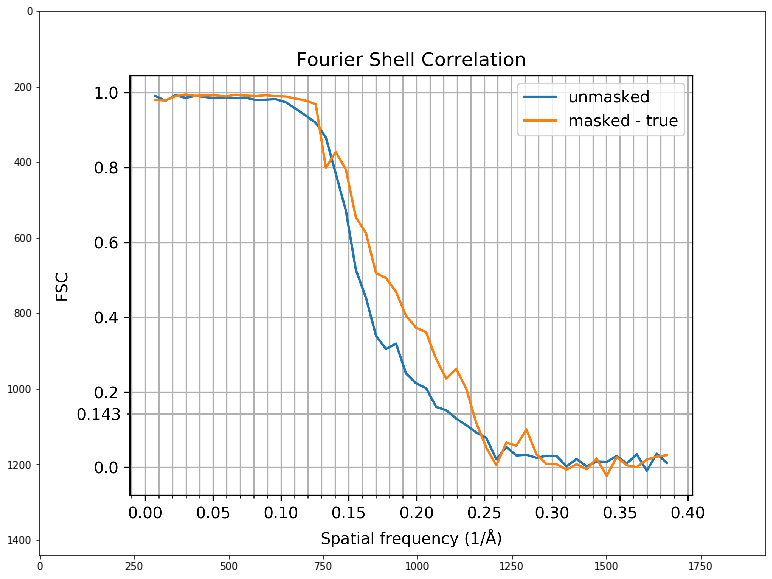

In [4]:
fsc = mpimg.imread('postprocess_fsc.png')
plt.rcParams['figure.figsize'] = [13,13] # To make figures appear larger
plt.imshow(fsc)

__TIP:__ You can use the `--svg` option to generate your FSC plots in vectorial format, which in turn you can edit using programs like Inkscape or Adobe Illustrator to change colors, add/remove grids, change fonts, etc.

__Of course, you will also want to inspect the mask and the postprocessed (un)masked 3D maps with your favorite 3D viewer (like [`Coot`](https://www2.mrc-lmb.cam.ac.uk/personal/pemsley/coot/), [`UCSF Chimera`](https://www.cgl.ucsf.edu/chimera/) or [`e2display.py`](https://blake.bcm.edu/emanwiki/EMAN2)).__

### Postprocessing using the molecular weight: `--mw`

Alternatively, we know the molecular weight of MloK1 is about 160 kDa. Instead of creating (or providing) a shaped mask, we could instead just apply a spherical mask and use this information to apply a "volume-normalization" to the FSC curve according to the "true" signal present in the box (this is the approach used in FREALIGN and cisTEM, called the "Single-Particle Wiener Filter" [[Sindelar & Grigorieff, JSB (2012)](https://doi.org/10.1016/j.jsb.2012.05.005)]):

In [5]:
%%bash

focus.postprocess EMD-4432/other/emd_4432_half_map_1.map EMD-4432/other/emd_4432_half_map_2.map --angpix 1.3 --mtf ../mtf/data_mtf_k2_300kv.star --auto_bfac -1,-1 --mask_radius 0.8 --mw 160.0 --out postprocess_mw

# The above command, explained line-by-line:
# 
# focus.postprocess EMD-4432/other/emd_4432_half_map_1.map EMD-4432/other/emd_4432_half_map_2.map \ # Call the program with the two half-maps
# --angpix 1.3 \ # Provide the correct pixel size
# --mtf ../mtf/data_mtf_k2_300kv.star \ # Provide the MTF .star file for sharpening
# --auto_bfac -1,-1 \ # Estimate sharpening B-factor automatically. Here -1,-1 means the default value for the low- and high-resolution limits for Guinier plot fitting.
# --mask_radius 0.8 \ # Combine the automatic mask with a spherical mask covering 80% the box size (specifically, the radius is 0.8 * 0.5 * box_size) 
# --mw 160.0 \ # The molecular weight of MloK1
# --out postprocess_mw # Default rootname for output (could be anything)


Calculating unmasked FSC...
FSC >= 0.143 until 4.507 A (unmasked)
Area under FSC (unmasked): 22.735

Calculating masked FSC...
FSC >= 0.143 until 4.097 A (masked)
Area under FSC (masked): 26.149

Calculating Single-Particle Wiener filter...

Fraction of particle within the volume (Fpart): 0.075490
Fraction of mask within the volume (Fmask): 0.213943
Fpart/Fmask ratio: 0.352849
FSC >= 0.143 until 3.976 A (volume-normalized)
Area under FSC (volume-normalized): 30.582

Averaging the two half-maps...
Applying FSC weighting (Cref) to the map...
Dividing map by the detector MTF...

Estimating contrast decay (B-factor) from Guinier plot between 10.000 A and 3.976 A...

Slope of fit: -31.7851
Intercept of fit: -3.2758
Correlation of fit: 0.84989
B-factor for contrast restoration: -127.1403 A^2

Band-pass filtering the map between resolution cutoffs 135.200 A and 3.976 A...
Masking the map...

Done!


Casting postprocess_mw-mask.mrc to `numpy.float64`


In this case, the FSC curves look like this:

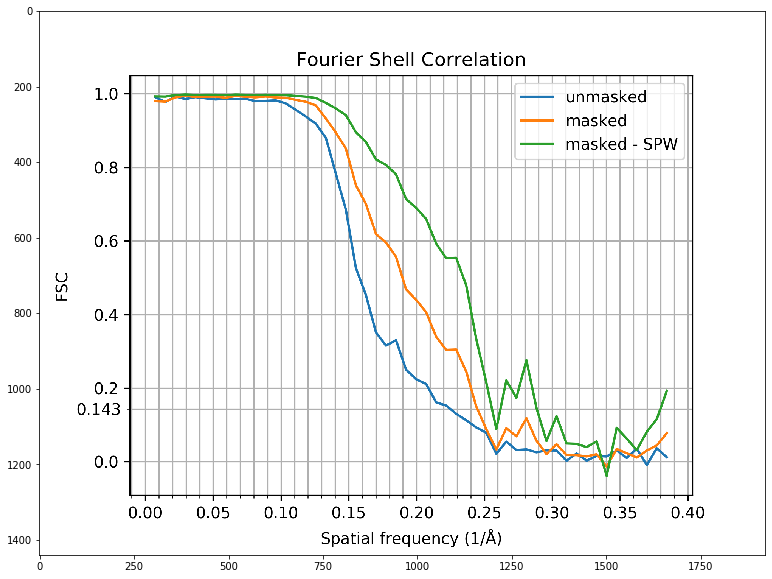

In [6]:
fsc = mpimg.imread('postprocess_mw_fsc.png')
plt.imshow(fsc)

The raw output from the postprocessing can be found in the file `postprocess_data.fsc`:

In [7]:
!cat postprocess_data.fsc

# /usr/local/bin/focus.postprocess EMD-4432/other/emd_4432_half_map_1.map EMD-4432/other/emd_4432_half_map_2.map --angpix 1.3 --mtf ../mtf/data_mtf_k2_300kv.star --auto_bfac -1,-1 --automask --mask_radius 0.8 --randomize_below_fsc 0.8 --out postprocess
# Res       	1/Res     	FSC-unmasked	FSC-masked	FSC-masked_true	Cref_Weights	InverseMTF	Auto_B-factor	Band-pass  	
999.000000	0.001001	1.000000	1.000000	1.000000	1.000000	1.014689	1.000043	1.000000
135.200000	0.007396	0.990753	0.980002	0.980002	0.994937	1.025643	1.002365	1.000000
67.600000	0.014793	0.977633	0.978758	0.978758	0.994618	1.047929	1.009495	1.000000
45.066667	0.022189	0.992609	0.990093	0.990093	0.997508	1.064454	1.021490	1.000000
33.800000	0.029586	0.985566	0.994571	0.994571	0.998638	1.072479	1.038524	1.000000
27.040000	0.036982	0.990849	0.991103	0.991103	0.997763	1.077157	1.060842	1.000000
22.533333	0.044379	0.987614	0.992276	0.992276	0.998060	1.081700	1.088772	1.000000
19.314286	0.051775	0.984605	0.992390	0.992390	0.998088	1